# Clickbait Image Classifier Pipeline

This notebook demonstrates the end-to-end process for building, evaluating, and interpreting an image-based clickbait classifier.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading & Exploration](#data-loading)
3. [Preprocessing](#preprocessing)
4. [Model Building](#model-building)
5. [Training](#training)
6. [Evaluation](#evaluation)
7. [Feature Visualization](#feature-visualization)
8. [Prediction Demo](#prediction-demo)
9. [Retraining Trigger](#retraining-trigger)

---

## 1. Introduction <a id='introduction'></a>

This notebook walks through the process of building a convolutional neural network (CNN) to classify images as clickbait or not. The pipeline includes data loading, preprocessing, model training, evaluation, and visualization of results.

In [9]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import random

# Set paths
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_PATH = '../models/clickbait_cnn.h5'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

## 2. Data Loading & Exploration <a id='data-loading'></a>

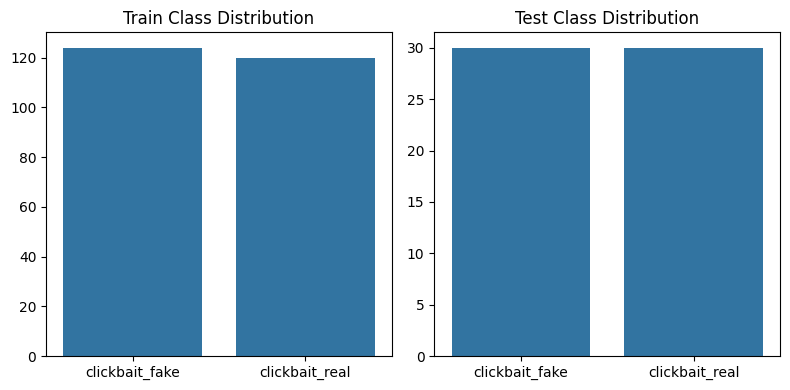

Train: {'clickbait_fake': 124, 'clickbait_real': 120}
Test: {'clickbait_fake': 30, 'clickbait_real': 30}


In [10]:
# Visualize class distribution
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Train Class Distribution')
plt.subplot(1,2,2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Test Class Distribution')
plt.tight_layout()
plt.show()

print('Train:', train_counts)
print('Test:', test_counts)

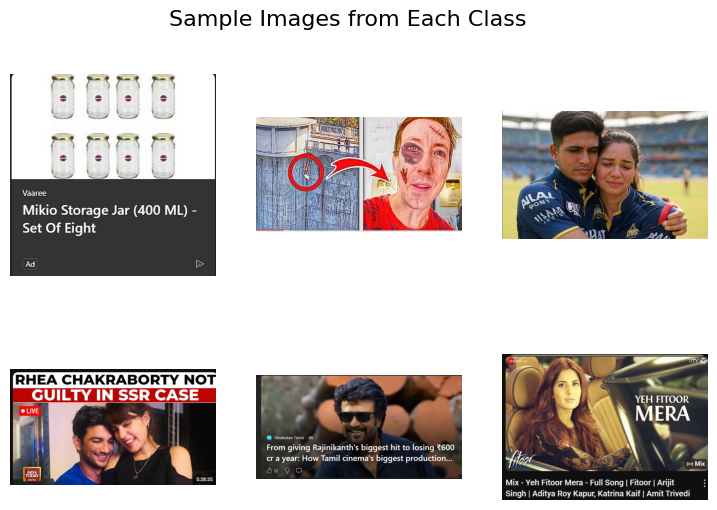

In [11]:
# Show random sample images from each class
def show_samples(directory, n=3):
    plt.figure(figsize=(n*3, 6))
    class_names = os.listdir(directory)
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)
        samples = random.sample(images, min(n, len(images)))
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(class_names), n, idx*n + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_name, fontsize=14)
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.show()

show_samples(TRAIN_DIR, n=3)

## 3. Preprocessing <a id='preprocessing'></a>

In [12]:
# Data generators with augmentation for training, only rescaling for test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

print('Class indices:', train_gen.class_indices)

Found 244 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Class indices: {'clickbait_fake': 0, 'clickbait_real': 1}


## 4. Model Building <a id='model-building'></a>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
# Call the model once with dummy data to build it
dummy_input = np.zeros((1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.float32)
_ = model.predict(dummy_input)
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

## 5. Training <a id='training'></a>

/opt/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5491 - loss: 1.7143
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to ../models/clickbait_cnn.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.5477 - loss: 1.6968 - val_accuracy: 0.5333 - val_loss: 0.6907
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6265 - loss: 1.0468
Epoch 2: val_accuracy did not improve from 0.53333
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.6261 - loss: 1.0439 - val_accuracy: 0.5167 - val_loss: 0.7244
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7350 - loss: 0.6170
Epoch 3: val_accuracy did not improve from 0.53333
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.7358 - loss: 0.6182 - val_accuracy: 0.5000 - val_loss: 0.7998
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6955 - loss: 0.5849
Epoch 4: val_accuracy did not improve from 0.53333
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.6974 - loss: 0.5856 - val_accuracy: 0.5000 - val_loss: 1.0473
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7486 - loss: 0.5141
Epoch 5: val_accuracy did not improve from 0.53333


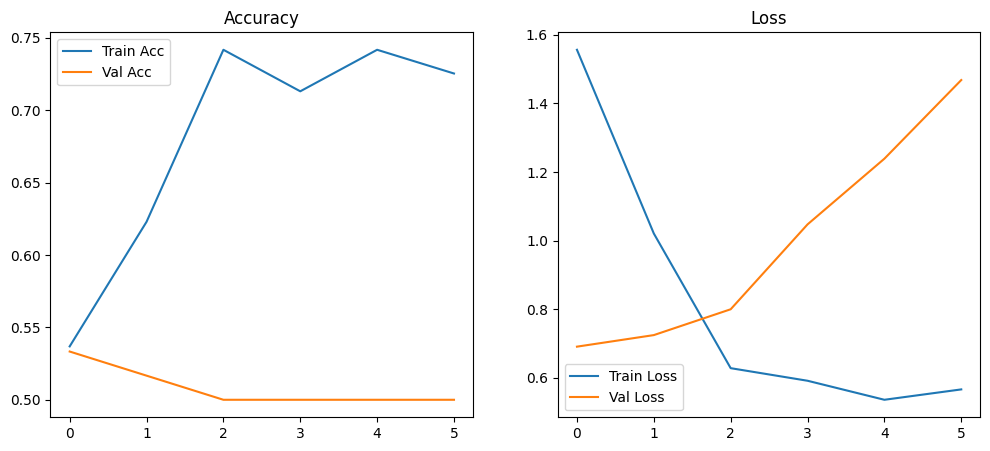

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 20

checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=[checkpoint, early_stop]
)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 6. Evaluation <a id='evaluation'></a>

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16662f240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Classification Report:
                precision    recall  f1-score   support

clickbait_fake       0.57      0.27      0.36        30
clickbait_real       0.52      0.80      0.63        30

      accuracy                           0.53        60
     macro avg       0.55      0.53      0.50        60
  weighted avg       0.55      0.53      0.50        60



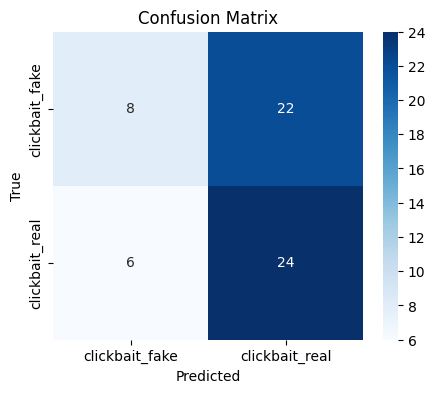

In [15]:
# Load best model
best_model = load_model(MODEL_PATH)

# Predict on test set
test_gen.reset()
preds = best_model.predict(test_gen, verbose=1)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Feature Visualization <a id='feature-visualization'></a>

Let's interpret what the model is learning using Grad-CAM for a few test images.

In [16]:
# # Grad-CAM visualization for a test image
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image

# def get_img_array(img_path, size):
#     img = image.load_img(img_path, target_size=size)
#     array = image.img_to_array(img)
#     array = np.expand_dims(array, axis=0)
#     array = array / 255.0
#     return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(predictions[0])
#         class_channel = predictions[:, pred_index]
#     grads = tape.gradient(class_channel, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# # Pick a random test image
# test_class = random.choice(os.listdir(TEST_DIR))
# test_img_name = random.choice(os.listdir(os.path.join(TEST_DIR, test_class)))
# test_img_path = os.path.join(TEST_DIR, test_class, test_img_name)

# img_array = get_img_array(test_img_path, IMAGE_SIZE)
# conv_layers = [layer.name for layer in best_model.layers if 'conv2d' in layer.name]
# last_conv_layer_name = conv_layers[-1]
# print("Using last Conv2D layer:", last_conv_layer_name)

# heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name=last_conv_layer_name)
# # Display heatmap
# import cv2
# img = cv2.imread(test_img_path)
# img = cv2.resize(img, IMAGE_SIZE)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.title('Original Image')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
# plt.title('Grad-CAM Heatmap')
# plt.axis('off')
# plt.suptitle(f'Grad-CAM for {test_class}', fontsize=16)
# plt.show()

## 8. Prediction Demo <a id='prediction-demo'></a>

In [17]:
# Predict on a new image
def predict_image(img_path, model, image_size=IMAGE_SIZE):
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    label = 'clickbait_fake' if pred > 0.5 else 'clickbait_real'
    confidence = float(pred) if pred > 0.5 else 1 - float(pred)
    return label, confidence

# Example usage
img_path = test_img_path  # Use the same image as above
label, confidence = predict_image(img_path, best_model)
print(f'Prediction: {label} (confidence: {confidence:.2f})')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: clickbait_real (confidence: 0.50)


## 9. Retraining Trigger <a id='retraining-trigger'></a>

You can retrain the model by running the training cells again or by calling the retraining endpoint in the API.